In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras.metrics import Accuracy, BinaryAccuracy, Precision, Recall
import datetime
from tensorflow.keras import models
from PIL import Image
import requests
import io
import time

import warnings
warnings.filterwarnings('ignore')

tf.get_logger().setLevel('INFO')

In [2]:
class F1_Score(tf.keras.metrics.Metric):

    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.f1 = self.add_weight(name='f1', initializer='zeros')
        self.precision_fn = Precision(thresholds=0.5)
        self.recall_fn = Recall(thresholds=0.5)

    def update_state(self, y_true, y_pred, sample_weight=None):
        p = self.precision_fn(y_true, y_pred)
        r = self.recall_fn(y_true, y_pred)
        # since f1 is a variable, we use assign
        self.f1.assign(2 * ((p * r) / (p + r + 1e-6)))

    def result(self):
        return self.f1

    def reset_states(self):
        # we also need to reset the state of the precision and recall objects
        self.precision_fn.reset_states()
        self.recall_fn.reset_states()
        self.f1.assign(0)

In [3]:
class SaveBestModel(tf.keras.callbacks.Callback):
    def __init__(self, save_best_metric='val_loss', this_max=False):
        self.save_best_metric = save_best_metric
        self.max = this_max
        if this_max:
            self.best = float('-inf')
        else:
            self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        metric_value = logs[self.save_best_metric]
        if self.max:
            if metric_value > self.best:
                self.best = metric_value
                self.best_weights = self.model.get_weights()

        else:
            if metric_value < self.best:
                self.best = metric_value
                self.best_weights= self.model.get_weights()

In [4]:
path = r"C:\Users\Admin\Desktop\Tensorboard_logs\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=path, histogram_freq=1)
class timecallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.times = []
        # use this value as reference to calculate cummulative time taken
        self.timetaken = time.clock()
    def on_epoch_end(self,epoch,logs = {}):
        self.times.append((epoch,time.clock() - self.timetaken))
    def on_train_end(self,logs = {}):
        plt.xlabel('Epoch')
        plt.ylabel('Total time taken until an epoch in seconds')
        plt.plot(*zip(*self.times))
        plt.show()
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=2)

In [5]:
train = ImageDataGenerator(rescale=1/255)
validation = ImageDataGenerator(rescale=1/255)

In [6]:
train_dataset = train.flow_from_directory(r'C:\Users\Admin\Desktop\fire\data\Dataset\Train',target_size=(250,250),batch_size=32,class_mode='binary',shuffle=True)
validation_dataset = validation.flow_from_directory(r'C:\Users\Admin\Desktop\fire\data\Dataset\Vali',target_size=(250,250),batch_size=32,class_mode='binary',shuffle=True)

Found 1520 images belonging to 2 classes.
Found 380 images belonging to 2 classes.


In [7]:
input_shape = (250, 250, 3)

In [8]:
model = tf.keras.models.Sequential([
        
        tf.keras.layers.Conv2D(filters = 64,
                                kernel_size = 3, 
                                activation='relu',
                                input_shape=input_shape),
    
        
    
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='valid'),
    
        tf.keras.layers.Conv2D(filters= 64,
                                kernel_size = 3,
                                activation='relu'),
    
        
    
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='valid'),
        
        tf.keras.layers.Conv2D(filters= 64,
                                kernel_size = 3,
                                activation='relu'),
    
        
    
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='valid'),

        tf.keras.layers.Conv2D(filters= 64,
                                kernel_size = 3,
                                activation='relu'),
    
       
    
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='valid'),
    
        tf.keras.layers.Dropout(0.2),

        tf.keras.layers.Flatten(),
    
        tf.keras.layers.Dense(1,activation='sigmoid')
        ])

In [9]:
model.compile(loss='binary_crossentropy',optimizer = 'adam',metrics=['accuracy',F1_Score()])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 48 steps, validate for 12 steps
Epoch 1/50
48/48 [==============================] - 257s 5s/step - loss: 0.2675 - accuracy: 0.8868 - f1_score: 0.8903 - val_loss: 0.3367 - val_accuracy: 0.8421 - val_f1_score: 0.8598
Epoch 2/50
48/48 [==============================] - 196s 4s/step - loss: 0.1445 - accuracy: 0.9526 - f1_score: 0.9529 - val_loss: 0.3225 - val_accuracy: 0.8921 - val_f1_score: 0.8983
Epoch 3/50
48/48 [==============================] - 151s 3s/step - loss: 0.1515 - accuracy: 0.9520 - f1_score: 0.9523 - val_loss: 0.2827 - val_accuracy: 0.8974 - val_f1_score: 0.8920
Epoch 4/50
48/48 [==============================] - 147s 3s/step - loss: 0.1237 - accuracy: 0.9605 - f1_score: 0.9607 - val_loss: 0.2546 - val_accuracy: 0.9026 - val_f1_score: 0.9073
Epoch 5/50
48/48 [==============================] - 149s 3s/step - loss: 0.1090 - accuracy: 0.9664 - f1_score: 0.9667 - val_loss: 0.2544 - val_accuracy: 0.9158 - val_f1_score: 

48/48 [==============================] - 145s 3s/step - loss: 6.0180e-05 - accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 0.4801 - val_accuracy: 0.9342 - val_f1_score: 0.9340
Epoch 45/50
48/48 [==============================] - 146s 3s/step - loss: 4.1820e-05 - accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 0.4849 - val_accuracy: 0.9368 - val_f1_score: 0.9365
Epoch 46/50
48/48 [==============================] - 152s 3s/step - loss: 2.6459e-05 - accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 0.4920 - val_accuracy: 0.9368 - val_f1_score: 0.9365
Epoch 47/50
48/48 [==============================] - 154s 3s/step - loss: 2.7079e-05 - accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 0.4936 - val_accuracy: 0.9368 - val_f1_score: 0.9365
Epoch 48/50
48/48 [==============================] - 152s 3s/step - loss: 3.9745e-04 - accuracy: 1.0000 - f1_score: 1.0000 - val_loss: 0.4394 - val_accuracy: 0.9395 - val_f1_score: 0.9399
Epoch 49/50
48/48 [==============================] - 153s 3s/step - loss

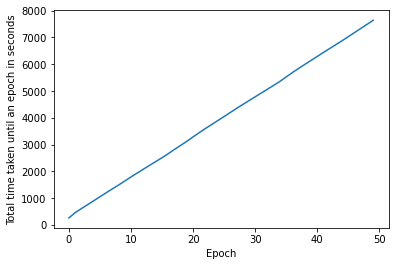

In [10]:
# In case we have hardware or resources limitations, we may use the following code and add it to callbacks in order to stop training
# after 2 epochs with no change in the val_loss:
# from tensorflow.keras.callbacks import EarlyStopping
# early_stop = EarlyStopping(monitor='val_loss',patience=2)

save_best_model = SaveBestModel()
model_fit = model.fit(train_dataset,epochs=50 ,validation_data=validation_dataset,callbacks=[tensorboard_callback,timecallback(),save_best_model])
model.set_weights(save_best_model.best_weights)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 248, 248, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 124, 124, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 59, 59, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 27, 64)        3

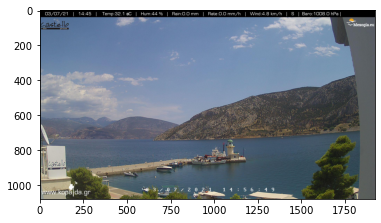

In [38]:
forests = [
'http://meteo.camera/mavroudi/?',
'http://www.livecamera.gr/webcam4/tinos4.jpg',
'http://www.northmeteo.gr/cam/astypalea/webcam.jpg?',
'https://www.cityofxanthi.gr/images/videos/xanthi1.jpg',
'http://www.stravon.gr/meteocams/aridaia/',
'https://www.livecameras.gr/thumbs/temp/ithak2.jpg',
'https://www.terracom.gr/sites/default/files/pictures/cam_01/cam05.jpg?',
'https://www.livecameras.gr/thumbs/temp/ithak2.jpg',
'http://www.zakynthos.at/zantecam/webcam.jpg',
'http://weather-messinia.gr/cams/paralia2.jpg',
'https://www.kopaida.gr/cams/antcam1.jpg'
]


for i in forests:
    try:
        im = Image.open(requests.get(i, stream=True).raw)
        plt.imshow(im)
    except:
        pass

In [39]:
from PIL import Image
fire,nonfire = 0,0
fire_photo =[]
for i in forests:
    try:
        x = Image.open(requests.get(i, stream=True).raw)
        X = x.resize((250,250),Image.ANTIALIAS)
        X = image.img_to_array(X)
        X = np.expand_dims(X,axis=0)
        val = model.predict(X)
        if val==0:
            fire+=1
            fire_photo.append(x)
            print('fire detected, please visit', i )
        else:
            nonfire+=1
            nofirephoto = i
            print('no fire detected')
    except:
        pass
    
print('total fires:', fire, ' of ', len(forests))
print('no fires:', nonfire, ' of ', len(forests))
print('could not connect to:', len(forests)-fire-nonfire)

no fire detected
no fire detected
no fire detected
no fire detected
no fire detected
no fire detected
no fire detected
no fire detected
no fire detected
no fire detected
total fires: 0  of  11
no fires: 10  of  11
could not connect to: 1


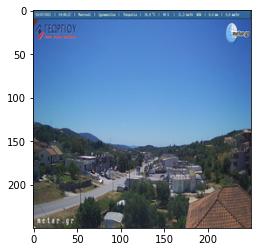

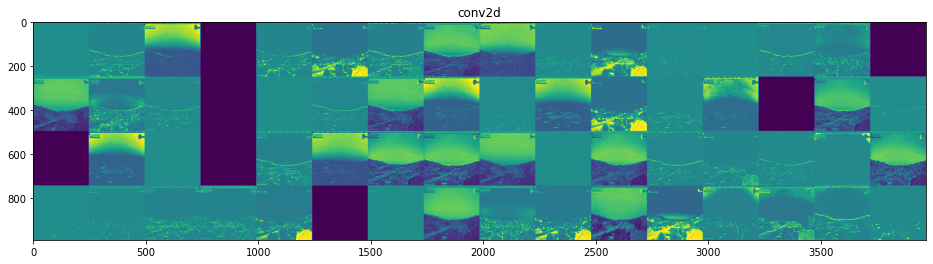

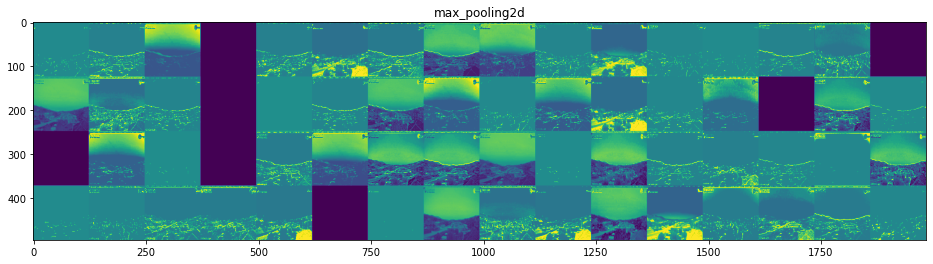

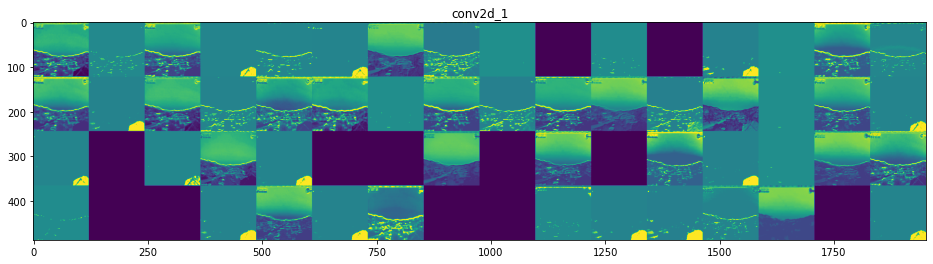

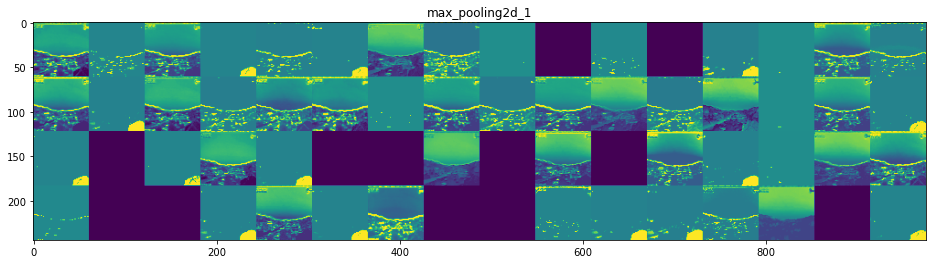

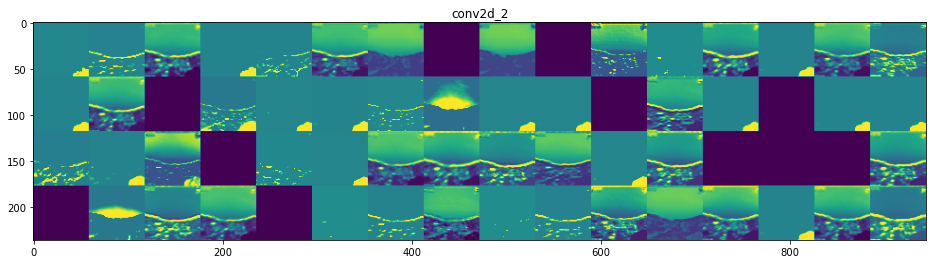

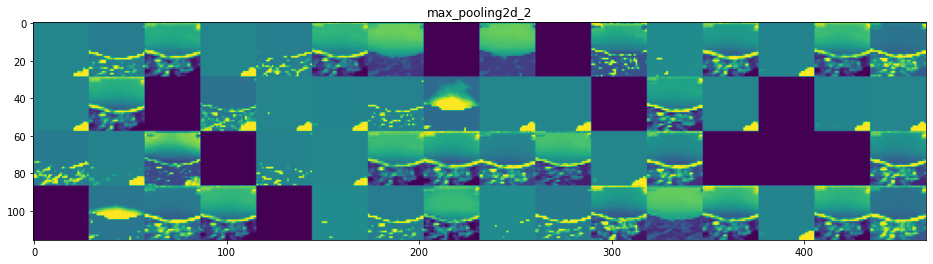

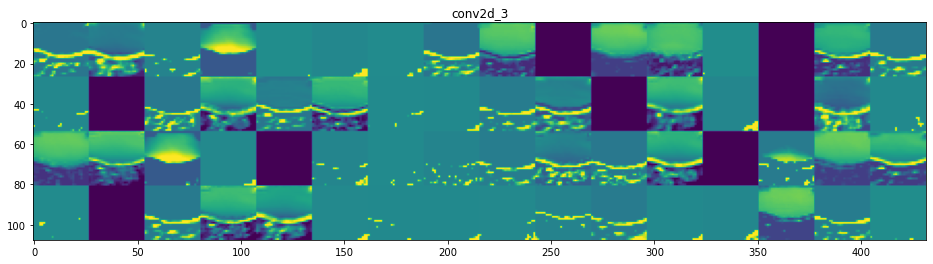

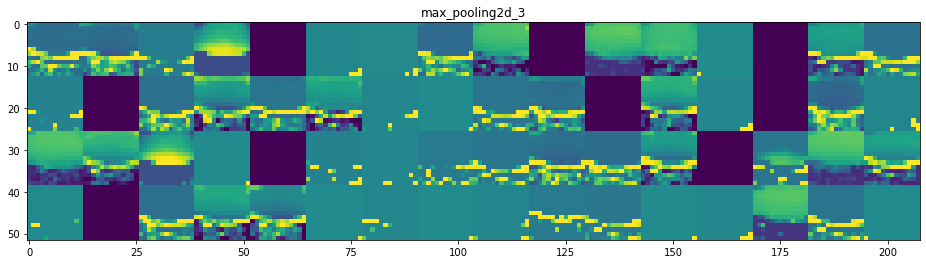

In [14]:
from PIL import Image
for i in range(len(forests)):
    try:
        x = Image.open(requests.get(forests[i], stream=True).raw)
        break
    except:
        pass
x = x.resize((250,250),Image.ANTIALIAS)
X = image.img_to_array(x)
X = np.expand_dims(X,axis=0)
plt.imshow(x)
layer_outputs = [layer.output for layer in model.layers[:]] 
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(X) 
# Returns a list of  Numpy arrays: one array per layer activation
len(activations)


images_per_row = 16

layer_names = []
for layer in model.layers[:]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot

for layer_name, layer_activation in zip(layer_names[:8], activations[:8]): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row #1 Tiles the activation channels in this matrix  
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

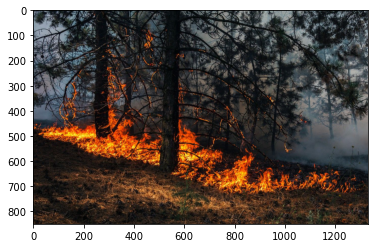

In [108]:
x = Image.open(requests.get(nofirephoto, stream=True).raw)
flame = Image.open(requests.get('https://wallpaperaccess.com/full/1817829.jpg', stream=True).raw)
plt.imshow(flame)

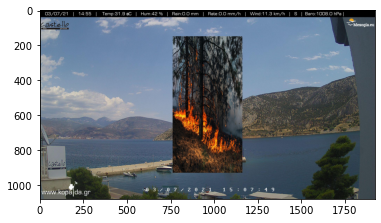

In [109]:
from PIL import Image
flame = flame.resize((400,780),Image.ANTIALIAS)
img_w, img_h = flame.size
bg_w, bg_h = x.size
offset = ((bg_w - img_w) // 2, (bg_h - img_h) // 2)
x.paste(flame, offset)
plt.imshow(x)

fire detected


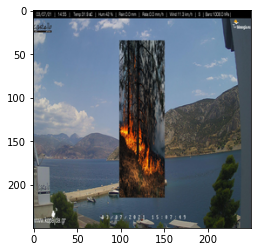

In [110]:
from PIL import Image
x = x.resize((250,250),Image.ANTIALIAS)
X = image.img_to_array(x)
X = np.expand_dims(X,axis=0)
augmented_test = model.predict(X)
if augmented_test==0:
    print('fire detected')
else:
    print('no fire detected')
    
#print(augmented_test)
plt.imshow(x)

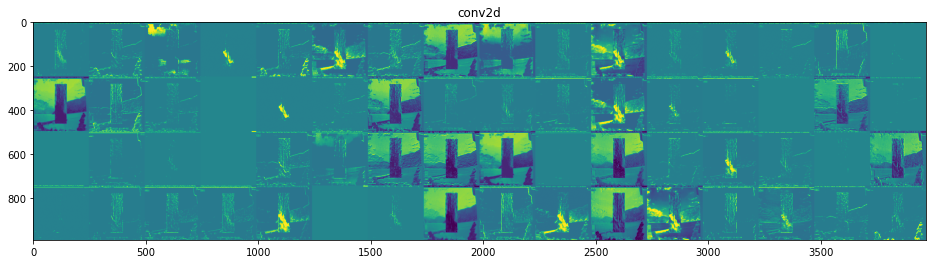

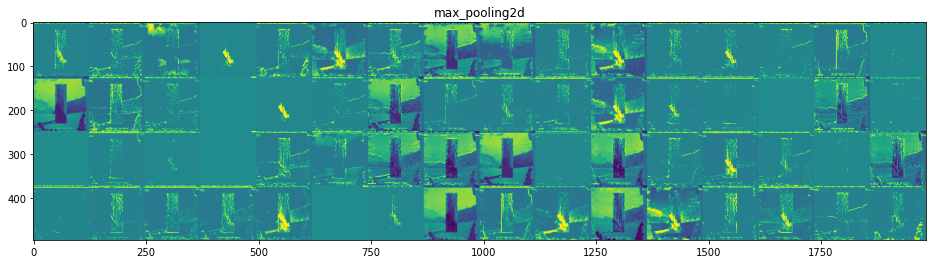

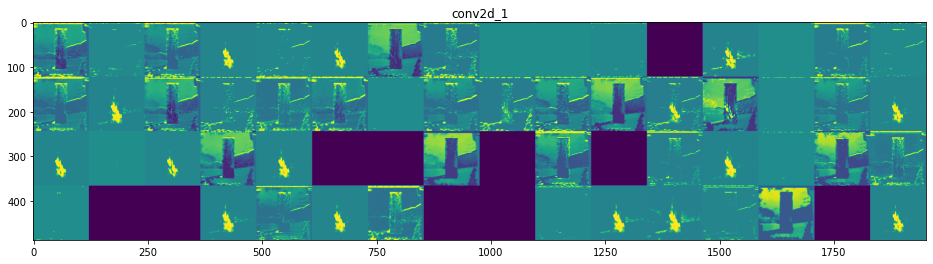

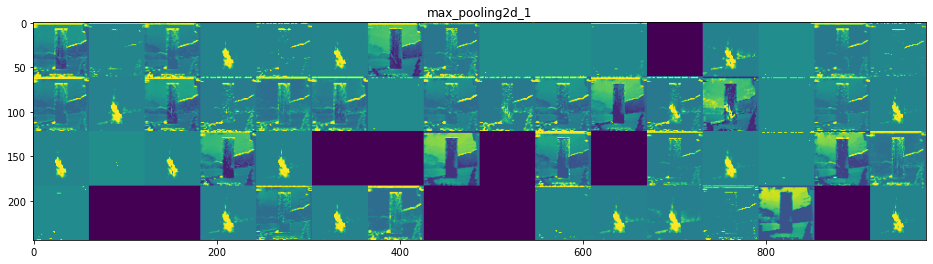

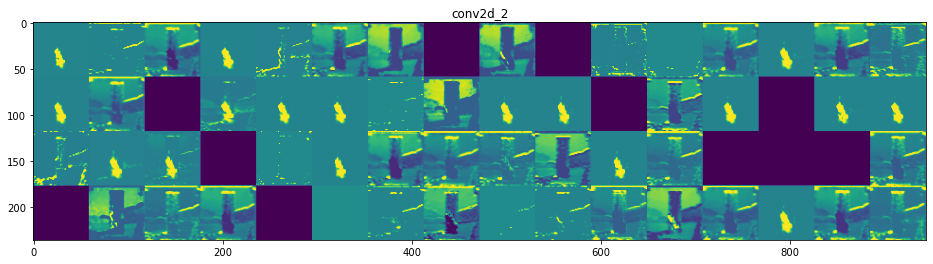

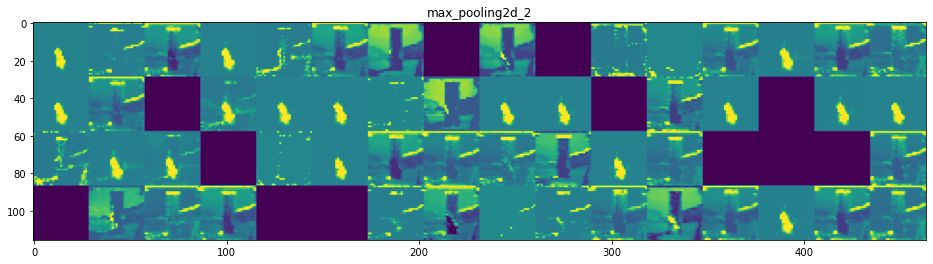

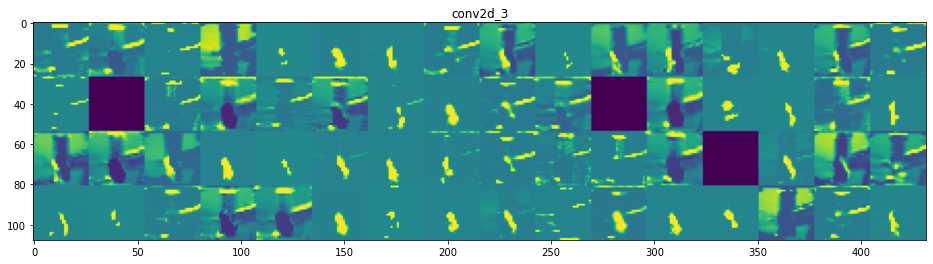

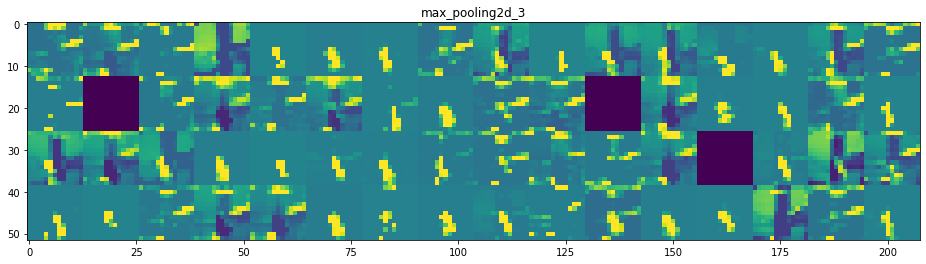

In [111]:
layer_outputs = [layer.output for layer in model.layers[:]] 
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(X) 
# Returns a list of  Numpy arrays: one array per layer activation
len(activations)


images_per_row = 16

layer_names = []
for layer in model.layers[:]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot

for layer_name, layer_activation in zip(layer_names[:8], activations[:8]): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row #1 Tiles the activation channels in this matrix  
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

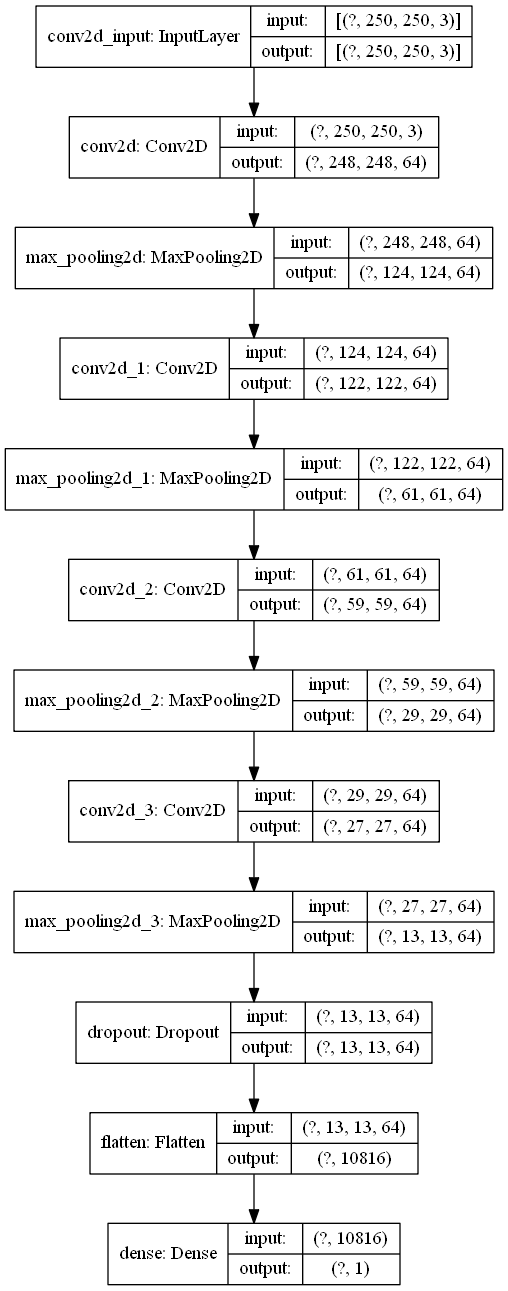

In [18]:
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='conv_base.png', show_shapes=True)
from IPython.display import Image
Image(filename='conv_base.png')

In [19]:
model.save(r'C:\Users\Admin\Desktop\my_model',save_format='tf')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: C:\Users\Admin\Desktop\my_model\assets


In [20]:
new_model = tf.keras.models.load_model(r'C:\Users\Admin\Desktop\my_model', custom_objects={"F1_Score": F1_Score}, compile=False)

In [21]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 248, 248, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 124, 124, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 59, 59, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 29, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 27, 64)        3